In [1]:
import plumed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

matplotlib.rcParams['svg.fonttype'] = 'none'

from SCRIPTS.func_block import reweight_2d, read_fes_2d, dG_calc

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [ ]:
SF = [0.8, 0.85, 1]
IONS = ['MG', 'CA']

FOLDERS = {
    'MG_0.8':'Ace-MG/u_0.8',
    'MG_1':'Ace-MG/u_1',
    'CA_0.8':'Ace-CA/u_0.8',
    'CA_0.85':'Ace-CA/u_0.85',
    'CA_1':'Ace-CA/u_1',

}

colors = {
    'CA_0.8': 'green',
    'CA_0.85': 'blue',
    'CA_1':'grey',
    'MG_0.8':'magenta',
    'MG_1':'r',

}

Tmin=1 #us
Tmax=3 #us

kBT=310*8.314462618*0.001 # kJ/mol
CV = ['dp', 'cn']

In [3]:
COLVARS = {}
for (k, v) in FOLDERS.items():
    print(k,v)
    cvlr = plumed.read_as_pandas(f'{v}/COLVAR')
    COLVARS[k] = cvlr[(Tmin*1000**2 < cvlr['time']) & (cvlr['time'] < Tmax*1000**2)]


MG_0.8 Ace-MG/u_0.8


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


MG_1 Ace-MG/u_1


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


CA_0.8 Ace-CA/u_0.8


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


CA_0.85 Ace-CA/u_0.85


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


CA_1 Ace-CA/u_1


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


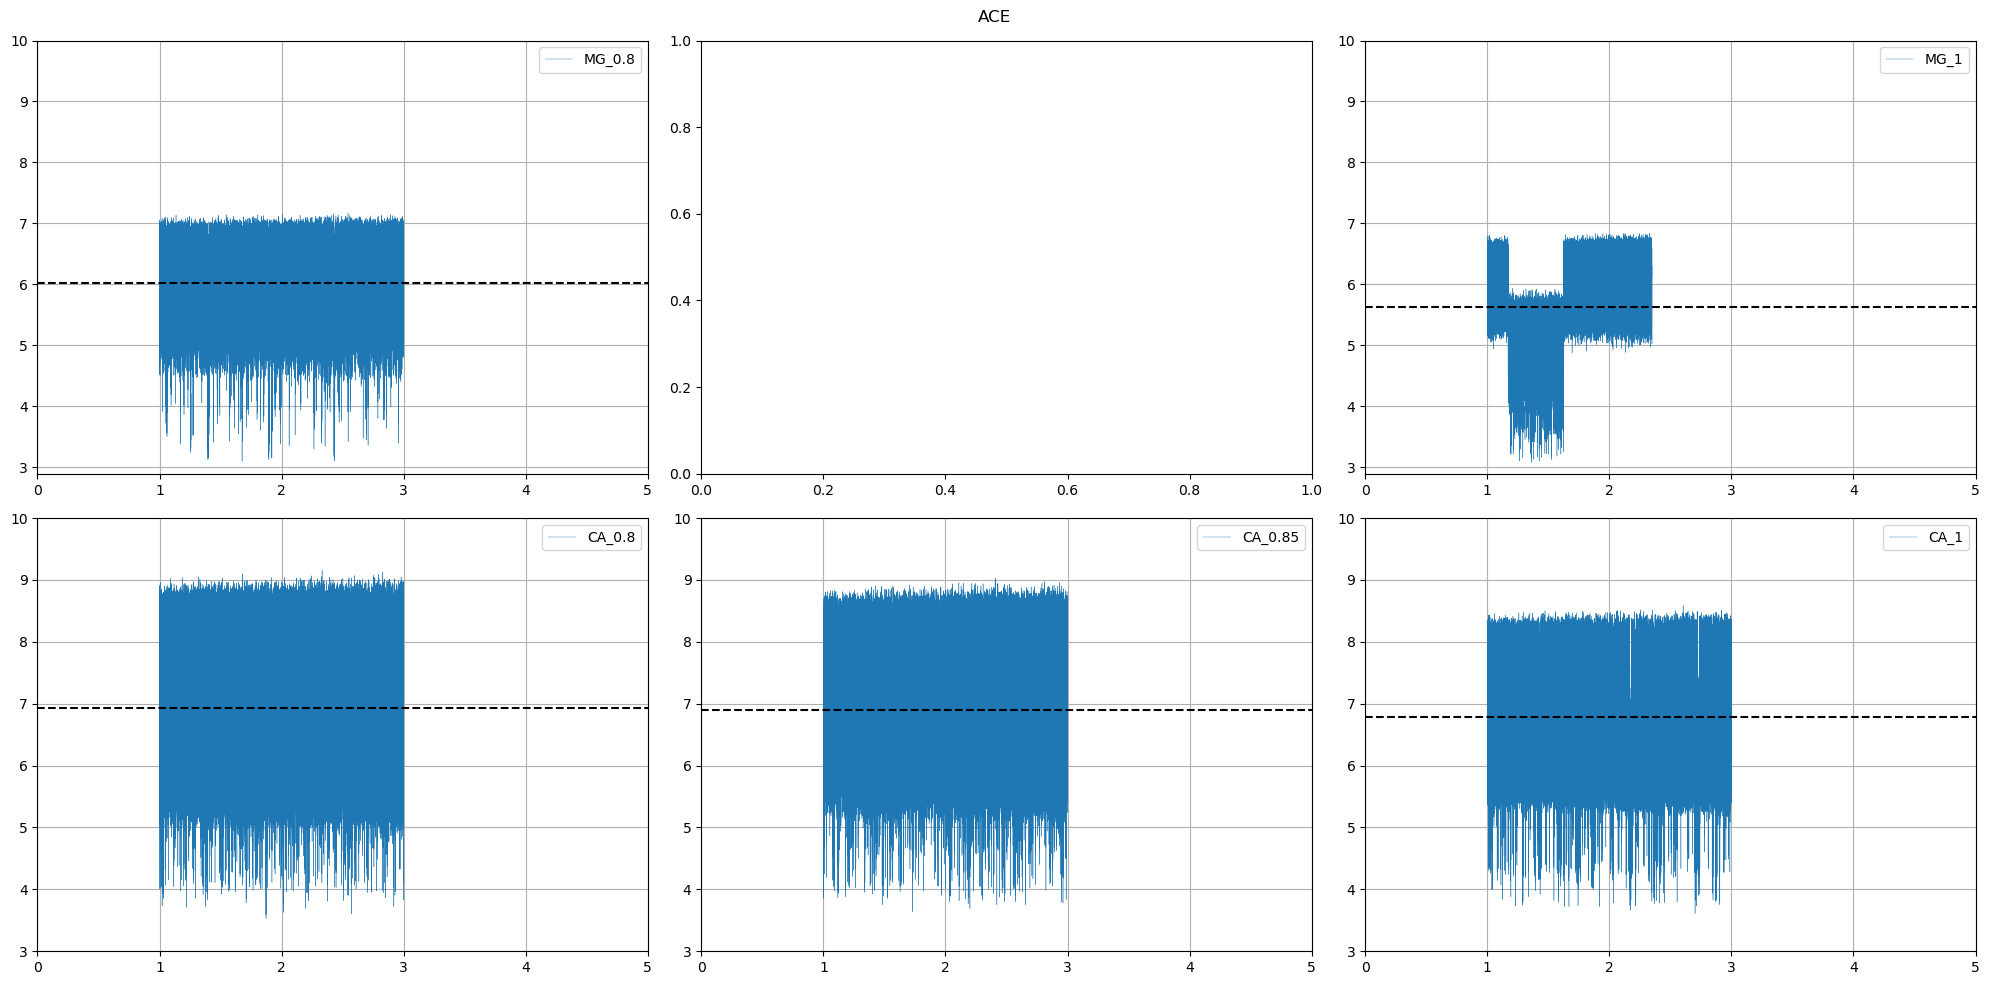

In [4]:
fig, ax = plt.subplots(len(IONS), len(SF), figsize = (20, 10))
for i in range(len(IONS)):
    for j in range(len(SF)):
        s = f'{IONS[i]}_{SF[j]}'
        if s in FOLDERS.keys():
            ax[i][j].plot(COLVARS[s]['time']/1000**2, COLVARS[s]['cn'], label = s, lw=0.3)
            ax[i][j].legend()
            ax[i][j].set_yticks([3, 4, 5, 6, 7, 8, 9, 10])
            ax[i][j].grid()
            ax[i][j].axhline(np.mean(COLVARS[s]['cn']), linestyle = '--', color = 'k')
            ax[i][j].set_xlim(0, 5)
plt.suptitle('ACE')
plt.tight_layout()
plt.savefig(f'IMAGES/ace_COLVAR_CN.svg', dpi=300, bbox_inches = 'tight')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


178 137 [0.0315449, 3.15281] [2.74549, 7.52194]


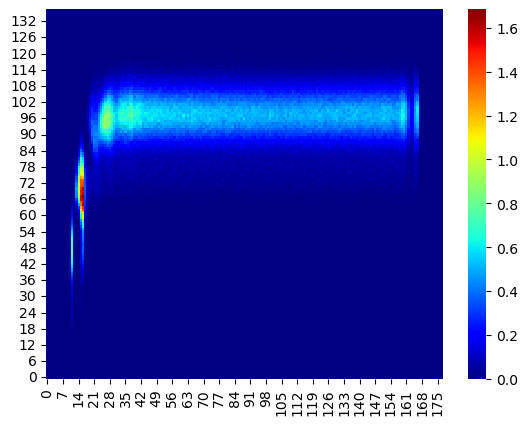

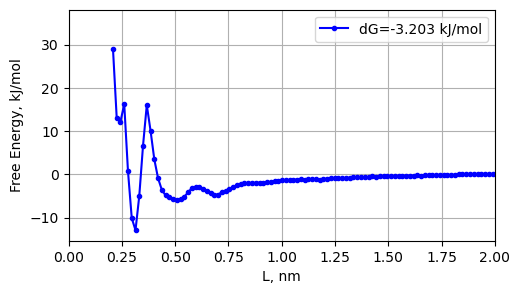

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


177 128 [0.0405492, 3.14872] [2.73024, 7.19482]


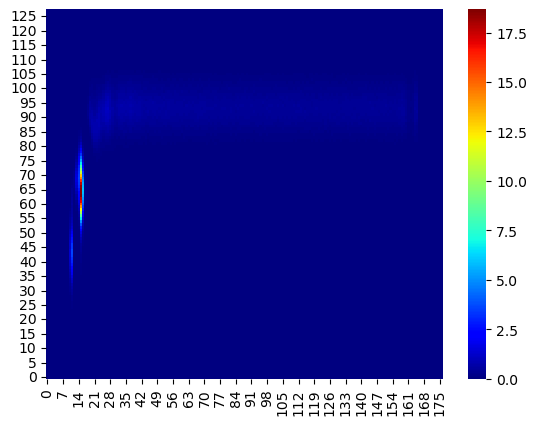

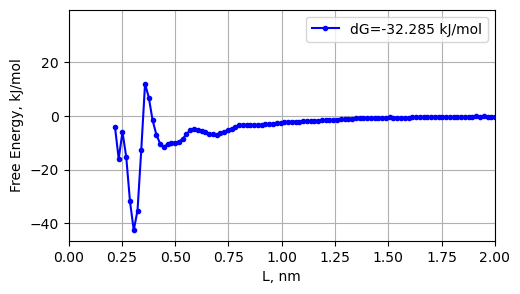

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


175 181 [0.0668522, 3.14052] [3.17414, 9.50791]


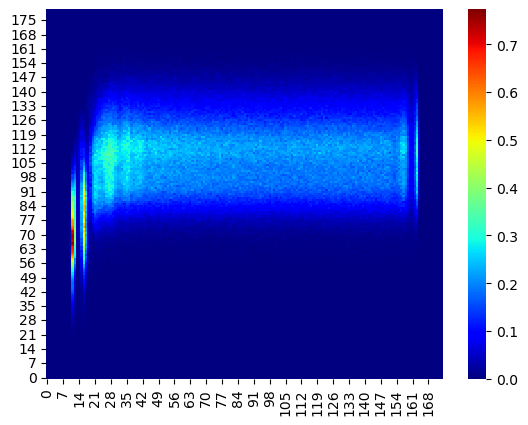

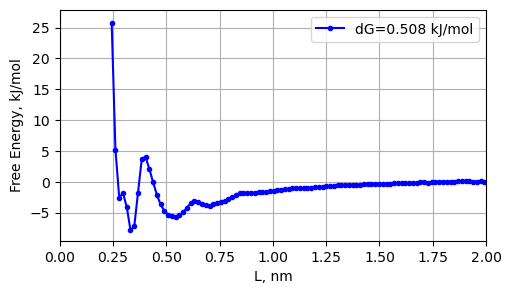

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


176 174 [0.0687757, 3.14946] [3.28703, 9.38322]


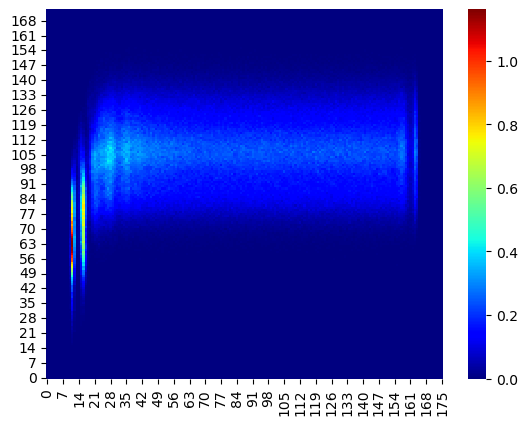

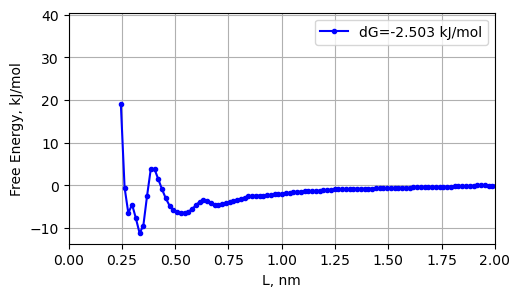

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


176 166 [0.0678646, 3.14947] [3.14725, 8.97841]


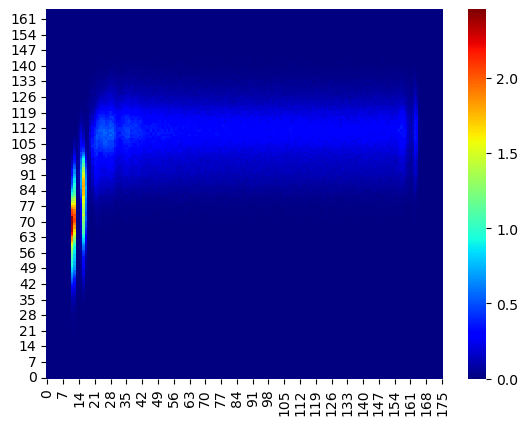

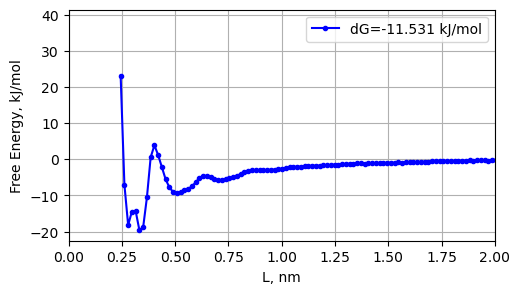

In [6]:
dist, cn, fes, Nbins_DP, Nbins_CN, Bonds_DP, Bonds_CN = {}, {}, {}, {}, {},  {}, {}
for (k, v) in FOLDERS.items():
    dist[k], cn[k], fes[k], Nbins_DP[k], Nbins_CN[k], Bonds_DP[k], Bonds_CN[k] = read_fes_2d(v)
    reweight_2d(0, -1, 
                 COLVARS[k], 
                dist[k], cn[k], fes[k], Nbins_DP[k], Nbins_CN[k], Bonds_DP[k], Bonds_CN[k], FOLDERS[k], 
                plot=True)

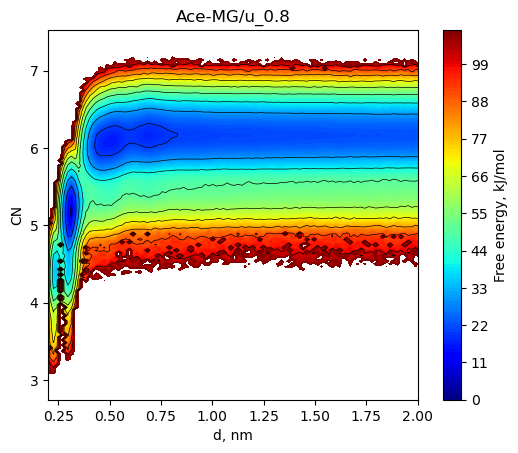

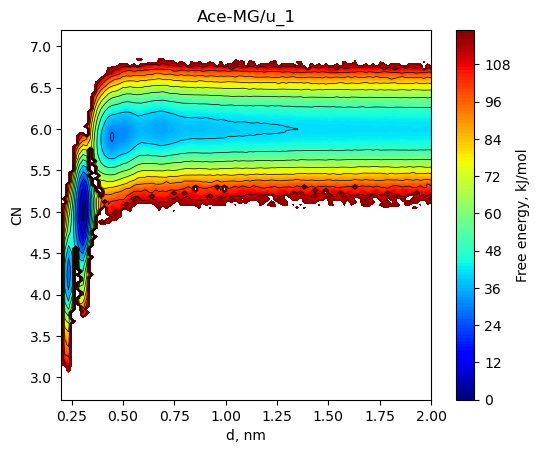

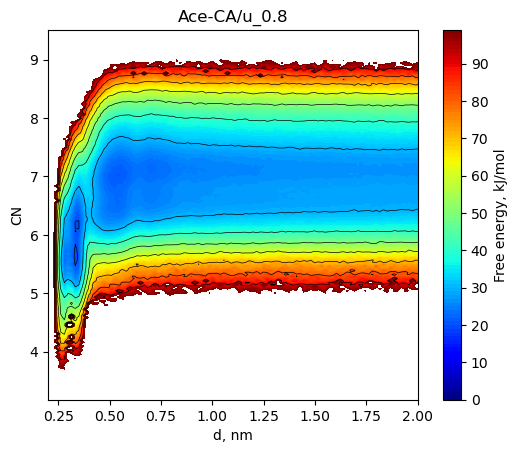

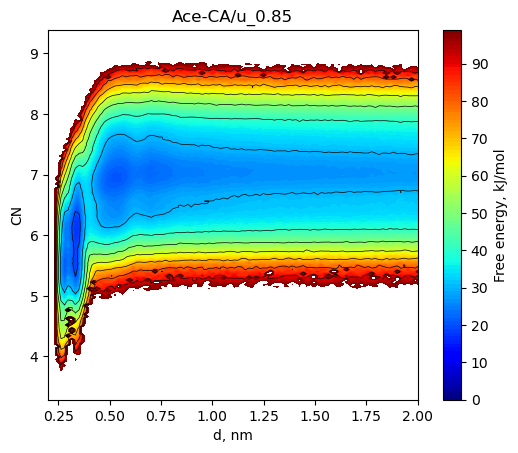

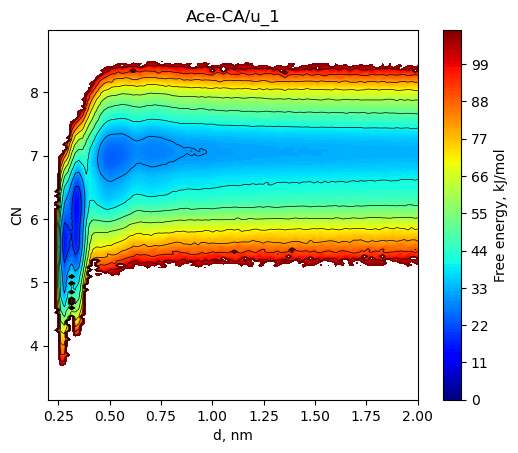

In [21]:
BIASF=5

for (k, v) in FOLDERS.items():
    Ubias = -fes[k].T * (1-1/BIASF) #4/5 #-(1-1/5) * fes_2d.to_numpy()
    
    WEIGHTS, ED = np.histogramdd(COLVARS[k][['dp', 'cn']].to_numpy(), 
                                bins = [Nbins_DP[k], Nbins_CN[k]],
                                range = (Bonds_DP[k], Bonds_CN[k]),
                                density=True, 
                                )
    weighted_avg = np.exp(1/kBT * (Ubias-np.max(Ubias))) * WEIGHTS
    norm = np.sum(np.exp(1/kBT * (Ubias-np.max(Ubias))))

    fes_2d = -kBT * np.log(weighted_avg/norm)
    fes_2d[fes_2d==np.inf] = np.nanmax(fes_2d[fes_2d<np.inf])
    
    fig, ax = plt.subplots()
    ax.set_box_aspect(1)
    vmax = np.nanmax(fes_2d)//10 * 10
    h = plt.contourf(dist[k], cn[k], fes_2d.T, 
                cmap = 'jet', 
                origin = 'lower',
                levels = np.arange(0, vmax, 1), 
                )

    plt.contour(dist[k], cn[k], fes_2d.T, 
                colors = 'k', 
                linewidths=0.5,
                levels = np.arange(0, vmax, 10)
                )
    
    plt.xlim(0.2, 2)
    
    plt.colorbar(h, label="Free energy, kJ/mol")
    plt.xlabel('d, nm')
    plt.ylabel("CN")
    plt.title(FOLDERS[k])
    plt.savefig(f'{FOLDERS[k]}/ace_prof_1D.svg', dpi=300, bbox_inches = 'tight')
    plt.show()


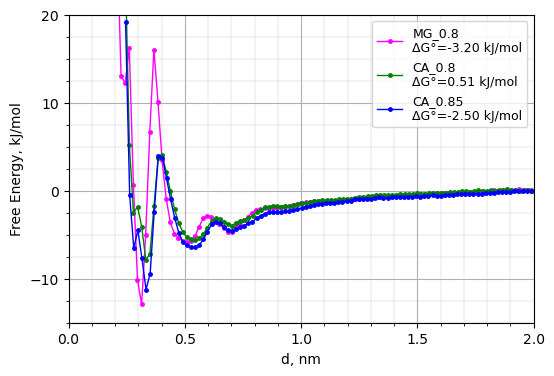

In [75]:
fig, ax = plt.subplots(figsize = (6, 4))

for (k, v) in FOLDERS.items():
    if k == 'MG_1' or k == 'CA_1': 
        continue
    prof_mg = pd.read_csv(f'{v}/prof_1D_reweight.dat', sep = ' ', header = None)
    dG = dG_calc(prof_mg[0], prof_mg[1], BOND_MAX=0.4, R_RES=0.7)
    plt.plot(prof_mg[0], prof_mg[1], '.-', lw=1,
             color = colors[k],
             label = f'{k}\nΔG°=%.2f kJ/mol' %dG, markersize = 5) #, markeredgecolor = 'k')

plt.ylim(-15, 20)
ax.grid(True, which='major', linestyle=  '-')
ax.grid(True, which='minor', linestyle=  '-', lw=0.2)
ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-100, 45, 10)))
ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-100, 45, 10/4)))

ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0, 3, 0.5)))
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(0, 3, 0.1)))

plt.xlim(0, 2)
plt.legend(loc = 'upper right', fontsize=9)#, ncol=2)
plt.xlabel('d, nm')
plt.ylabel('Free Energy, kJ/mol')
plt.savefig(f'IMAGES/ace_prof_1D.svg', dpi=300, bbox_inches = 'tight')

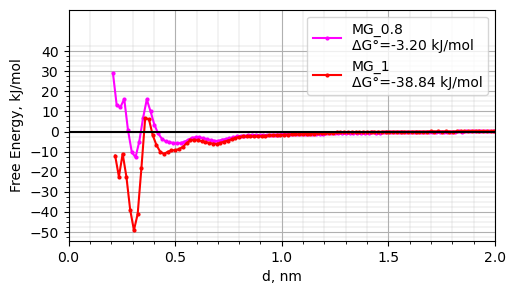

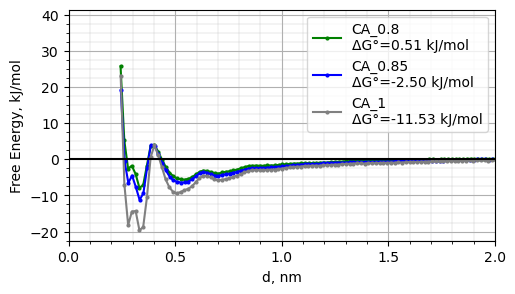

In [8]:
for ion in IONS:    
    fig, ax = plt.subplots(figsize = (5.5, 3))

    for (k, v) in FOLDERS.items():
        if k.split('_')[0] != ion: 
            continue
        prof_mg = pd.read_csv(f'{v}/prof_1D_reweight.dat', sep = ' ', header = None)
        dG = dG_calc(prof_mg[0], prof_mg[1], BOND_MAX=0.4, R_RES=0.7)

        plt.plot(prof_mg[0], prof_mg[1], '.-', 
                color = colors[k],
                label = f'{k}\nΔG°=%.2f kJ/mol' %dG, markersize = 4) #, markeredgecolor = 'k')

    # plt.ylim(-20, 20)
    ax.grid(True, which='major', linestyle=  '-')
    ax.grid(True, which='minor', linestyle=  '-', lw=0.2)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-100, 45, 10)))
    ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-100, 45, 10/4)))

    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0, 3, 0.5)))
    ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(0, 3, 0.1)))

    ax.axhline(0, color = 'k')
    plt.xlim(0, 2)
    plt.legend()
    plt.xlabel('d, nm')
    plt.ylabel('Free Energy, kJ/mol')
    plt.savefig(f'IMAGES/ace_{ion}_prof_1D.svg', dpi=300, bbox_inches = 'tight')
    plt.show()

In [41]:
def calc_dGmeanstd(COLVAR, dist, cn, fes, Nbins_DP, Nbins_CN, Bonds_DP, Bonds_CN, FOLDER):
    # N = np.arange(100, 1010, 100)*1000 #2 ** np.arange(4, 11)*1000
    CVLR=COLVAR #COLVAR.iloc[1000**2+1:3*1000**2+1]
    N_blocks = np.arange(3, 100, 5)

    dG_mean = np.zeros_like(N_blocks).astype(float)
    dG_std = np.zeros_like(N_blocks).astype(float)

    for i in range(len(N_blocks)): 
        dG_cur = []
        dt = len(CVLR)//N_blocks[i]
        #print(N_blocks[i])
        for j in range(0, len(CVLR), dt):
            #print(len(CVLR[j:j+dt]), CVLR[j:j+dt]) 
            dG_ = reweight_2d(0, -1, CVLR[j:j+dt], dist, cn, fes, Nbins_DP, Nbins_CN, Bonds_DP, Bonds_CN, FOLDER, plot=False)
            if np.isnan(dG_) == False and dG_ < np.inf and dG_ > -np.inf:
                dG_cur.append(dG_)
        #print(len(dG_cur), dG_cur)
        dG_mean[i] = np.mean(dG_cur)
        dG_std[i] = np.std(dG_cur)/np.sqrt(len(dG_cur)) #len(np.where(~np.isnan(dG_cur))[0])  #scipy.stats.sem(dG_cur, nan_policy='omit') #np.nanstd(dG_cur) / np.sqrt(len(dG_cur[~np.isnan(dG_cur)]))

    return (CVLR, N_blocks, dG_mean, dG_std)


In [42]:
# k = "CA_1"
# calc_dGmeanstd(COLVARS[k], dist[k], cn[k], fes[k], Nbins_DP[k], Nbins_CN[k], Bonds_DP[k], Bonds_CN[k], FOLDERS[k])

In [43]:
CVLR, N_blocks, dG_mean, dG_std = {}, {}, {}, {}
for (k, v) in FOLDERS.items():
    CVLR[k], N_blocks[k], dG_mean[k], dG_std[k] = calc_dGmeanstd(COLVARS[k], dist[k], cn[k], fes[k], Nbins_DP[k], Nbins_CN[k], Bonds_DP[k], Bonds_CN[k], FOLDERS[k])

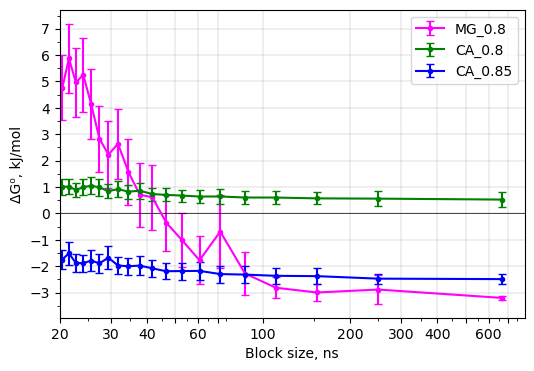

In [72]:

fig, ax = plt.subplots(figsize = (6, 4))

for (k, v) in FOLDERS.items():
    if k == 'MG_1' or k == 'CA_1':
        continue
    plt.errorbar(len(CVLR[k])/N_blocks[k]/1000, 
                 dG_mean[k], dG_std[k], fmt='.-',
                color = colors[k],
                capsize=3, 
                label=k,
                )


plt.xlabel('Block size, ns')
plt.ylabel('ΔG⁰, kJ/mol')

ax.grid(True, which='major', linestyle='-', lw=0.3,)
# ax.grid(True, which='minor', linestyle='-', lw=0.2)
# ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 2)))
ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 1)))
ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 0.5)))

# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

plt.legend()

plt.xscale('log')

xticks = ax.xaxis.get_minor_ticks()
for tick in xticks:
    tick.label1.set_visible(False)

plt.xlim(20, 800)  # Устанавливаем пределы оси X

ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.1)))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.05)))

formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
ax.xaxis.set_major_formatter(formatter)

plt.axhline(0, color = 'k', lw=0.5)#, alpha = 0.4)
plt.savefig(f'IMAGES/ace_dG_diffSF.svg', bbox_inches ='tight', dpi=300)
plt.show()

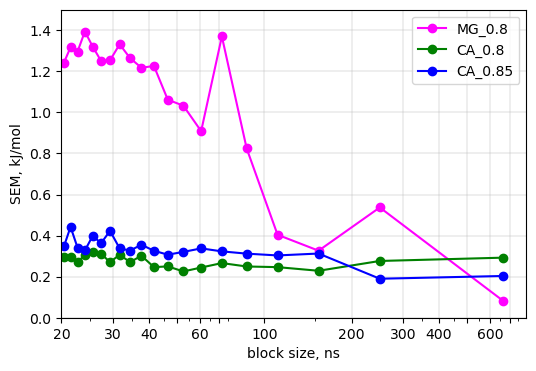

In [74]:
fig, ax = plt.subplots(figsize = (6, 4))
for (k, v) in FOLDERS.items():
    if k == 'MG_1' or k == 'CA_1':
        continue

    plt.plot(len(CVLR[k])/N_blocks[k]/1000, dG_std[k], 'o-', 
            color = colors[k],

             label = k)

plt.ylabel('SEM, kJ/mol')
plt.grid()
plt.xlabel('block size, ns')
plt.xscale('log')
plt.ylim(0, 1.5)
plt.xlim(0, 1000)

# ax.grid(True, which='major', linestyle='-', lw=0.3,)

# xticks = ax.xaxis.get_minor_ticks()
# for tick in xticks:
#     tick.label1.set_visible(False)

# plt.xlim(20, 800) 

# ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.1)))

# formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
# ax.xaxis.set_major_formatter(formatter)

# plt.legend()
ax.grid(True, which='major', linestyle='-', lw=0.3,)
# ax.grid(True, which='minor', linestyle='-', lw=0.2)
# ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 2)))
# ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 1)))
# ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 0.5)))

# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

plt.legend()

plt.xscale('log')

xticks = ax.xaxis.get_minor_ticks()
for tick in xticks:
    tick.label1.set_visible(False)

plt.xlim(20, 800)  # Устанавливаем пределы оси X

ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.1)))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.05)))

formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
ax.xaxis.set_major_formatter(formatter)

plt.axhline(0, color = 'k', lw=0.5)#, alpha = 0.4)

plt.savefig(f'IMAGES/ace_dG_SEM_diffSF.svg', bbox_inches ='tight', dpi=300)

plt.show()

In [51]:

# dG_last = pd.DataFrame(index=N_blocks[k][:lastN][::-1])
dG_fin = pd.DataFrame(columns = ['dG', 'err'], index = FOLDERS.keys())
for (k, v) in FOLDERS.items():
    prof_mg = pd.read_csv(f'{v}/prof_1D_reweight.dat', sep = ' ', header = None)
    dG_fin['dG'][k] = dG_calc(prof_mg[0], prof_mg[1], BOND_MAX=0.4, R_RES=0.7)

lastN=4
SEM_last = pd.DataFrame(index=N_blocks[k][:lastN][::-1])
for (k, v) in FOLDERS.items():
    SEM_last[k] = dG_std[k][:lastN][::-1]
SEM_last = SEM_last.T
SEM_last['mean'] = SEM_last.mean(axis=1)
display(SEM_last.round(2))
dG_fin['err'] = SEM_last['mean']

display(dG_fin.astype(float).round(1))

,18,13,8,3,mean
MG_0.8,0.40,0.33,0.54,0.08,0.34
MG_1,4.40,5.37,6.90,11.67,7.08
CA_0.8,0.25,0.23,0.28,0.29,0.26
CA_0.85,0.30,0.31,0.19,0.20,0.25
CA_1,0.39,0.28,0.23,0.11,0.25


,dG,err
MG_0.8,-3.2,0.3
MG_1,-32.3,7.1
CA_0.8,0.5,0.3
CA_0.85,-2.5,0.3
CA_1,-11.5,0.3


In [55]:
def _plot_stride_dG(k):

    stride = pd.read_csv(f'{FOLDERS[k]}/stride_reweight/dG_bond.csv', sep = '\t', header = None, 
                            names = ['t', 'dG1', 'dG2'])
    stride['t'] /= 10
    # if FOLDERS[i].split('/')[0].split('.')[-1] == "multiwalkers": 

    plt.plot(stride['t'], stride['dG1'], '.-', color = colors[k], label = FOLDERS[k],
             markeredgecolor = 'k', markeredgewidth = 0.5)
    plt.plot(stride['t'], stride['dG2'], '.-',  color = colors[k], markeredgecolor = 'k', 
             markeredgewidth = 0.5)


    plt.xlabel('T, μs')
    plt.ylabel('ΔG, kJ/mol')
    plt.legend()

    plt.xlim(0, 3)
    plt.ylim(-20, 20)

    plt.grid(True, which='major', linestyle=  '-')
    plt.grid(True, which='minor', linestyle=  '-', lw=0.2)

    plt.axhline(0, color = 'k', lw = 0.5)
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0, 10.1, 0.5)))
    ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(0, 10.1, 0.1)))

    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-100, 100, 5)))
    ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-100, 100, 1)))

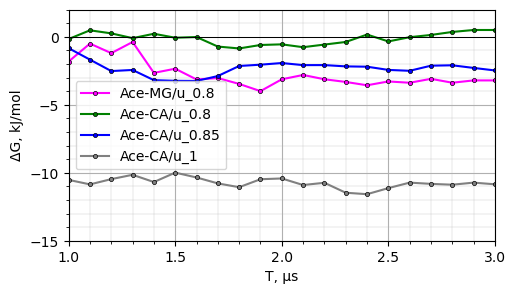

In [56]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for (k, v) in FOLDERS.items():
    if k == 'MG_1':
        continue
    _plot_stride_dG(k)
    # plt.ylim(-50, 10)
    plt.ylim(-15, 2)
    plt.xlim(1, 3)